# Marijuana Sales Prediction

## Projects Objective
- Goal: Predict sales of each brand
- Sub-problems: 

## Import Required Libraries

In [175]:
# import systems tools 
import os 
import sys

# import numerical tools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings


## Load Data
- Load from local dataset

In [176]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
# import required packages
import sys
import os
import pandas as pd
# Load Dataset
avgRetail = pd.read_csv("../data/BrandAverageRetailPrice.csv")
brandDetail = pd.read_csv("../data/BrandDetails.csv")
totalSales = pd.read_csv("../data/BrandTotalSales.csv")
totalUnits = pd.read_csv("../data/BrandTotalUnits.csv")

## Construct Dataset 
- Time-series data
    - Convert into same time-stamp format
- Clean Data 
    - without imputation
- Feature Engineering
    - Feature augmentation
    - Combining feature in same/different datasets

### Find the dataset to start with
- Criteria: Information of each datasets
- Objective: Since the final goal is to predict the future sales, we start with the dataset that seems to have strong correlation with sales, and also with few feature to start with. 

#### Total Sales dataset

In [177]:
totalSales.info()
totalSales.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


#### Total units dataset

In [178]:
totalUnits.info()
totalUnits.head(5)
# find out how many brand do we have currently

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            27686 non-null  object 
 1   Months            27686 non-null  object 
 2   Total Units       25712 non-null  object 
 3   vs. Prior Period  24935 non-null  float64
dtypes: float64(1), object(3)
memory usage: 865.3+ KB


,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,08/2020,"1,616.3390040000000",NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,715.5328380000000,NaN
3,#BlackSeries,02/2021,766.669135,0.071466
4,#BlackSeries,03/2021,NaN,-1.000000


### Clean the choosen dataset
- Selected dataset: Total Sales
- Breakdown: Base-on different brand
- Reason: 
    - It contains more information about salses. 
    - It has much narrow data in brand features. 

#### Preprocess the selected dataset

In [179]:
# convert the time stamp dataset
totalSales["Months"] = totalSales["Months"].astype(str).astype('datetime64[ns]')
# convert salses data to numerical data form
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].str.replace(',','')
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].astype(float)
totalSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


#### Find out all the brand name

In [180]:
brands = list(totalSales["Brand"].unique())
print("==================================")
print("Total: {} different brands".format(brands.__len__()))
print("==================================")

Total: 1627 different brands


#### Select Brand with Enough Data
- Start with the brand that has much information. 

============Current Threshold for Number of Data: 37===========


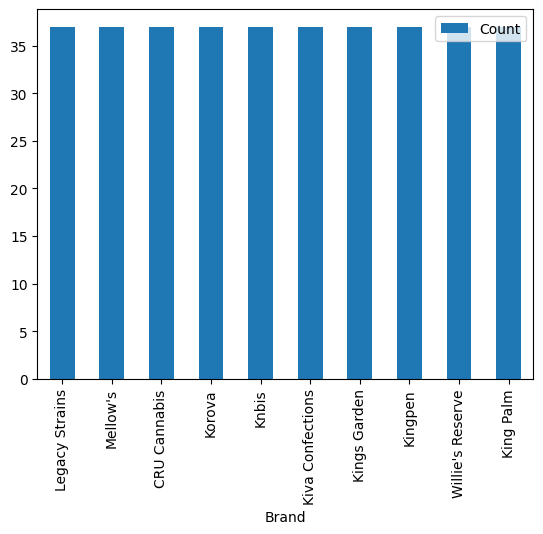

In [181]:
import matplotlib.pyplot as plt
# start with one of the brand
# only list-out top three brand
brands_data_num = pd.DataFrame()
brands_data_num.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
brands_data_num.loc[:, "Count"] = [1]*len(totalSales["Brand"])
brands_data_num = brands_data_num.groupby(["Brand"]).sum().sort_values("Count", ascending=False)

# Only pick the brands with enough number of data
numDataThreshold = brands_data_num["Count"].max()
print("============Current Threshold for Number of Data: {}===========".format(numDataThreshold))
brands_filtered = brands_data_num[brands_data_num.Count >= numDataThreshold]
brands_filtered.head(10).plot(kind="bar")
plt.show()

### Feature Engineering 
- Transform and add more features in the selected dataset. 
- Add more features from other related datasets. 

#### Sales info about selected brand

In [182]:
brandName = brands_filtered.index[2]
brandData = totalSales[totalSales.Brand == brandName].drop(['Brand'], 1)

#### Adding Features to Dataset

In [183]:
#  adding from current dataset 
#==============add last month data===============================================
brandData.loc[:, 'Previous Month Sales'] = brandData.loc[:,"Total Sales ($)"].shift(-1)

#===========Adding Rolling Sales Data===========
# add rolling sales data (for three months)
# calcualte the sum
rollSum, rollMonths = 0, 3
for month in range(1, rollMonths + 1): 
    rollSum += brandData.loc[:,"Total Sales ($)"].shift(-1 * month)
brandData.loc[:, 'Rolling Sales (3 months)'] = rollSum / rollMonths

# add rolling sales data (for six months)
rollSum, rollMonths = 0, 6
for month in range(1, rollMonths + 1): 
    rollSum += brandData.loc[:,"Total Sales ($)"].shift(-1 * month)
brandData.loc[:, 'Rolling Sales (6 months)'] = rollSum / rollMonths

brandData.head()

,Months,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months)
97,2018-09-01,304936.750181,4.062828e+05,626537.153755,7.674090e+05
557,2018-10-01,406282.842541,6.100694e+05,747385.740716,8.514012e+05
1049,2018-11-01,610069.442623,8.632592e+05,936734.801876,9.190416e+05
1580,2018-12-01,863259.176100,7.688286e+05,908280.892597,9.193758e+05
2114,2019-01-01,768828.603426,1.178117e+06,955416.649863,1.037832e+06


##### Add from total_unit dataset

In [184]:
# general info
brandUnits = totalUnits[totalUnits.Brands == brandName]
brandUnits["Months"] = pd.to_datetime(brandUnits["Months"])
brandUnits["Total Units"] = brandUnits["Total Units"].str.replace(',','')
brandUnits["Total Units"] = brandUnits["Total Units"].astype(float)
brandUnits = brandUnits.drop(['Brands'], 1)
#===================Merge Data==================
brandData = brandData.merge(brandUnits, right_on="Months", left_on="Months")
brandData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Months                    37 non-null     datetime64[ns]
 1   Total Sales ($)           37 non-null     float64       
 2   Previous Month Sales      36 non-null     float64       
 3   Rolling Sales (3 months)  34 non-null     float64       
 4   Rolling Sales (6 months)  31 non-null     float64       
 5   Total Units               37 non-null     float64       
 6   vs. Prior Period          37 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.3 KB


##### Add from average retail price dataset

In [185]:
# Convert months column data into datetime
brandARP = avgRetail[avgRetail.Brands == brandName].drop(['Brands'], 1)
brandARP["Months"] = pd.to_datetime(brandARP["Months"])
# rename the features name
# since in the total_units dataset, ther is also a feature
# called "vs. Prior Period"
brandARP = brandARP.rename(columns={"vs. Prior Period" : "vs. Prior Period (ARP)"})

# merge the feature into the sales dataset)
brandData = brandData.merge(brandARP, left_on="Months", right_on="Months")
brandData = brandData.rename(columns={"vs. Prior Period" : "vs. Prior Period (Totla Units)"})
brandData.head(10)

,Months,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months),Total Units,vs. Prior Period (Totla Units),ARP,vs. Prior Period (ARP)
0,2018-09-01,3.049368e+05,4.062828e+05,6.265372e+05,7.674090e+05,28596.673305,-0.516234,10.663364,NaN
1,2018-10-01,4.062828e+05,6.100694e+05,7.473857e+05,8.514012e+05,38675.748698,0.352456,10.504848,-0.014866
2,2018-11-01,6.100694e+05,8.632592e+05,9.367348e+05,9.190416e+05,56451.526425,0.459610,10.806961,0.028759
3,2018-12-01,8.632592e+05,7.688286e+05,9.082809e+05,9.193758e+05,83177.778198,0.473437,10.378483,-0.039648
4,2019-01-01,7.688286e+05,1.178117e+06,9.554166e+05,1.037832e+06,68912.534404,-0.171503,11.156586,0.074973
5,2019-02-01,1.178117e+06,7.778974e+05,9.013483e+05,1.132119e+06,112063.453044,0.626169,10.512942,-0.057692
6,2019-03-01,7.778974e+05,9.102359e+05,9.304706e+05,1.286051e+06,69077.125447,-0.383589,11.261289,0.071183
7,2019-04-01,9.102359e+05,1.015912e+06,1.120247e+06,1.480665e+06,84807.893325,0.227728,10.732915,-0.046920
8,2019-05-01,1.015912e+06,8.652644e+05,1.362891e+06,1.677053e+06,86636.133978,0.021557,11.726189,0.092545
9,2019-06-01,8.652644e+05,1.479564e+06,1.641632e+06,1.895434e+06,77104.506326,-0.110019,11.221969,-0.042999


##### Add from brand details dataset

In [186]:
import numpy as np
# info aobut brain details
bdData = brandDetail[brandDetail.Brand == brandName]

bdColNames = bdData.columns.tolist()
for feature in bdColNames: 
    print(feature)

State
Channel
Category L1
Category L2
Category L3
Category L4
Category L5
Brand
Product Description
Total Sales ($)
Total Units
ARP
Flavor
Items Per Pack
Item Weight
Total THC
Total CBD
Contains CBD
Pax Filter
Strain
Is Flavored
Mood Effect
Generic Vendor
Generic Items
$5 Price Increment


In [187]:
brandDetail.head()

,State,Channel,Category L1,Category L2,Category L3,Category L4,Category L5,Brand,Product Description,Total Sales ($),...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),"1,103.964857",...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),674.645211,...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
2,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),"2,473.699102",...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),"14,589.916417",...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Wax,NaN,101 Cannabis Co.,101 Cannabis Co. - Afghan Kush - Wax,145.39627,...,0,0,THC Only,NaN,Afghan Kush,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


In [255]:
brandDetail["$5 Price Increment"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 144977 entries, 0 to 144976
Series name: $5 Price Increment
Non-Null Count   Dtype 
--------------   ----- 
144977 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


##### L1 Category Analysis 
- Find out which type of products has largest portion in the total sales
- Conclusion: 
    1. Inhaleables and Ingestibles type of product has the largest portion of income sales. 
    2. It will make inhaleables and ingestibles an important features for the model. 
- Action: 
    1. Adding "Inhaleables" and "Ingestibles" as new feature in the dataaset. 

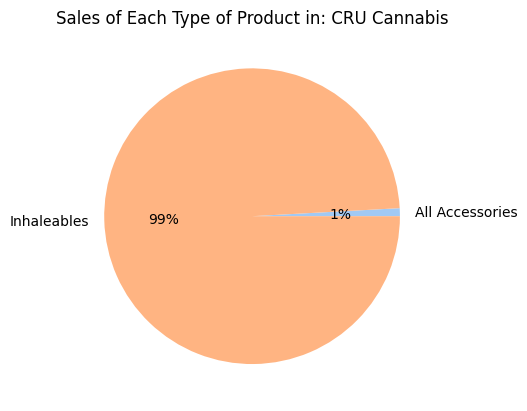

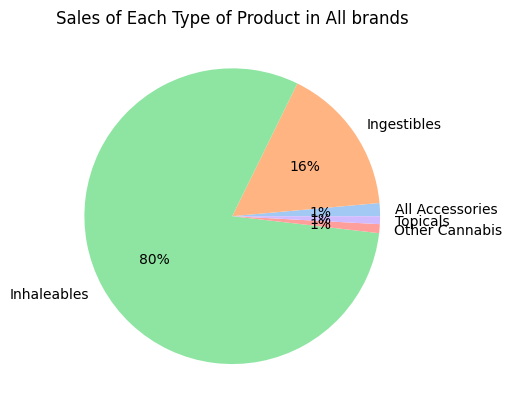

In [188]:
# Find percentage of the Inhaleable and Ingestible product in current selected brand
brandSales = pd.DataFrame()
studyData = bdData.copy()
brandSales.loc[:, "Category"] = studyData.loc[:, "Category L1"]
brandSales.loc[:, "Sales"] = studyData.loc[:, "Total Sales ($)"].str.replace(',', '').astype(float)
brandSales = brandSales.groupby(by="Category").sum()
brandSalesIndex = brandSales.index
colors = sns.color_palette('pastel')[0:5]
plt.pie(brandSales["Sales"], labels=brandSalesIndex, colors=colors, autopct='%.0f%%')
plt.title("Sales of Each Type of Product in: " + brandName)
plt.show()

# Find percentage of the Inhaleable and Ingestible product in all brand
brandSalesAll = pd.DataFrame()
studyData = brandDetail.copy()
brandSalesAll.loc[:, "Category"] = studyData.loc[:, "Category L1"]
brandSalesAll.loc[:, "Sales"] = studyData.loc[:, "Total Sales ($)"].str.replace(',', '').astype(float)
brandSalesAll = brandSalesAll.groupby(by="Category").sum()
brandSalesAllIndex = brandSalesAll.index
colors = sns.color_palette('pastel')[0:5]
plt.pie(brandSalesAll["Sales"], labels=brandSalesAllIndex, colors=colors, autopct='%.0f%%')
plt.title("Sales of Each Type of Product in All brands")
plt.show()

In [189]:
# adding L1 Inhaleables and Ingestible into the datasets
brandData.loc[:, "Inhaleables"] = int("Inhaleables" in brandDetail["Category L1"].values)
brandData.loc[:, "Ingestibles"] = int("Ingestibles" in brandDetail["Category L1"].values)
brandData.head()

,Months,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months),Total Units,vs. Prior Period (Totla Units),ARP,vs. Prior Period (ARP),Inhaleables,Ingestibles
0,2018-09-01,304936.750181,4.062828e+05,626537.153755,7.674090e+05,28596.673305,-0.516234,10.663364,NaN,1,1
1,2018-10-01,406282.842541,6.100694e+05,747385.740716,8.514012e+05,38675.748698,0.352456,10.504848,-0.014866,1,1
2,2018-11-01,610069.442623,8.632592e+05,936734.801876,9.190416e+05,56451.526425,0.459610,10.806961,0.028759,1,1
3,2018-12-01,863259.176100,7.688286e+05,908280.892597,9.193758e+05,83177.778198,0.473437,10.378483,-0.039648,1,1
4,2019-01-01,768828.603426,1.178117e+06,955416.649863,1.037832e+06,68912.534404,-0.171503,11.156586,0.074973,1,1


##### Previous Salese Correlation
- Features 
    1. Previos Sales
    2. 3 months rolling sales
    3. 6 months rolling sales
- Conclusion: All three features have strong correlation to each other

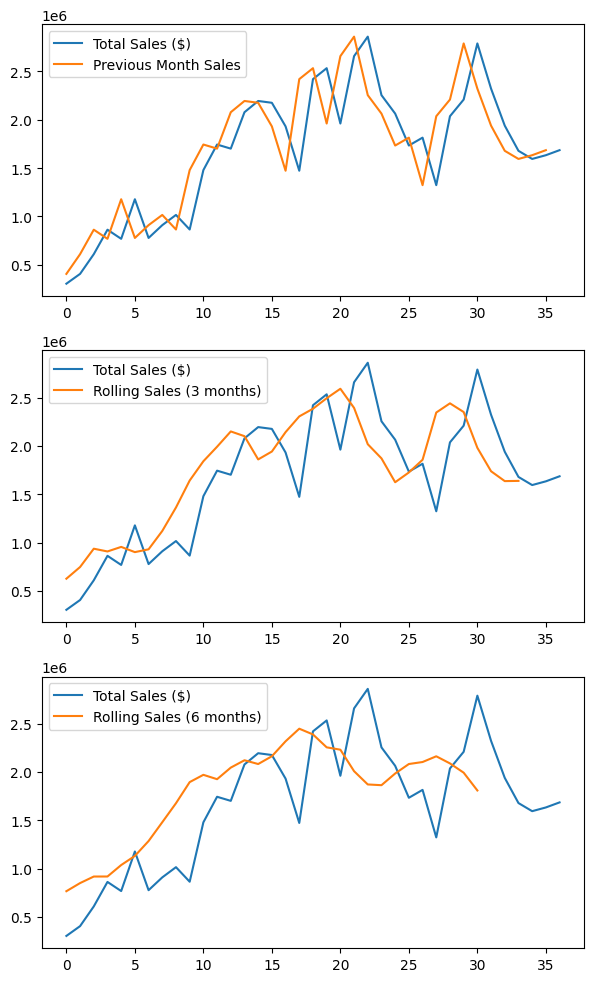

In [253]:
# previous sales
fig, axis = plt.subplots(3, 1, figsize=(7, 12))
brandData.plot.line(y="Total Sales ($)", ax=axis[0])
brandData.plot.line(y="Previous Month Sales", ax=axis[0])

brandData.plot.line(y="Total Sales ($)", ax=axis[1])
brandData.plot.line(y="Rolling Sales (3 months)", ax=axis[1])

brandData.plot.line(y="Total Sales ($)", ax=axis[2])
brandData.plot.line(y="Rolling Sales (6 months)", ax=axis[2])
plt.show()

## Explore Data 
- Visualize Data 
- Explore data (correlation)
- Objective of features combination

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
brandData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Months                          37 non-null     datetime64[ns]
 1   Total Sales ($)                 37 non-null     float64       
 2   Previous Month Sales            36 non-null     float64       
 3   Rolling Sales (3 months)        34 non-null     float64       
 4   Rolling Sales (6 months)        31 non-null     float64       
 5   Total Units                     37 non-null     float64       
 6   vs. Prior Period (Totla Units)  37 non-null     float64       
 7   ARP                             37 non-null     float64       
 8   vs. Prior Period (ARP)          36 non-null     float64       
 9   Inhaleables                     37 non-null     int64         
 10  Ingestibles                     37 non-null     int64         
dtypes: datet

In [ ]:
# 

## Data Preprocessing
- Develope several pipeline
- Visualize pipelines 
- (pipeline update -- base on training result) 

### Create Preprocessing Pipelines

In [196]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

#=================Individal Pipeline===================
#******************Sales data******************
sales_features = [
    "Total Sales ($)", 
    "Previous Month Sales", 
    "Rolling Sales (3 months)", 
    "Rolling Sales (6 months)", 
    "ARP", 
    "vs. Prior Period (ARP)"
]
sales_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler() # normalize data
)

#******************Units data******************
units_features = [
    "Total Units",
    "vs. Prior Period (Totla Units)"
]
units_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler() # normalize data
)

#*****************Product data******************
productType_features = [
    "Inhaleables", 
    "Ingestibles"
]
productType_pipeline = make_pipeline(
    KNNImputer(n_neighbors=2), 
    StandardScaler()
)

#***************Default Pipelien*****************
# for numerical and category specifically
num_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OrdinalEncoder(),
    StandardScaler()
)

#======================Final Preprocess Pipeline======================
preprocess = ColumnTransformer([
    ("Sales", sales_pipeline, sales_features),  # sales features pipeline
    ("Units", units_pipeline, units_features),  # total units features pipeline
    ("Product_type", productType_pipeline, productType_features), # different type of products pipeline
    ("Default_cat", cat_pipeline, make_column_selector(dtype_include=object))    
    ],
    remainder= num_pipeline
)

### Preprocess Data

In [201]:
# drop the months data
if "Months" in brandData.columns.to_list():
    print("Drop feature: {}".format("Months"))
    brandData = brandData.drop("Months", axis=1)
else: 
    print("Feature {} has already been dropped.".format("\"Months\""))

# extract the index of the label data columns 
y_index = brandData.columns.to_list().index("Total Sales ($)")
# preprocess the data
brandData_prep = preprocess.fit_transform(brandData)
# extract input and output data for machine learning
X, y = np.delete(brandData_prep, y_index, 1), brandData_prep[:, y_index]
print("Input datasets has #{} of data with {} features".format(X.shape[0], X.shape[1]))
print("Output label has #{} of data".format(y.shape[0]))


Feature "Months" has already been dropped.
Input datasets has #37 of data with 9 features
Output label has #37 of data


## Hyper-parameters

In [219]:
# initialize all hypterparameters in dictionary forms
params = {
    "test_ratio" : 0.1, 
    "learning_rate" : 1e-3, 
    "batch_size": 5, 
    "stop_point" : 200
}
# print-out all hyperparameters
print(params)

{'test_ratio': 0.1, 'learning_rate': 0.001, 'batch_size': 5, 'stop_point': 200}


## Split Datasets
- Split into training/validation and testing dataset

In [220]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params["test_ratio"])
print(X_train.shape)
print(X_test.shape)

(33, 9)
(4, 9)


## Deploy ML/DL
- Model selection
- Comparison between each baseline models
- Select best baseline model
- Search for best parameters (grid/random search)

### Linear Model

#### Linear Regression 

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# initialize model
model = LinearRegression()
# train model
model.fit(X_train, y_train)
# test model
y_predict = model.predict(X_test)
error = mean_squared_error(y_test, y_predict)
print(f"Error rate {error}")

Error rate 0.000854582061193666


#### Cross Validation Score

In [237]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# initialize parameters
bestScore = -1
bestCV = 0
for cv in range(2, 10):
    # initialize model
    model = LinearRegression()
    score = cross_val_score(model, X_train, y_train, cv=cv)
    meanScore = sum(score)/len(score)
    if meanScore > bestScore:
        bestScore = meanScore
        bestCV = cv 

print("Best cross validation split: {}".format(bestCV))


Best cross validation split: 3


### Trees Model

## Visualize Result 
- Visualization result
    - Tableau
    - Seaborn
- Check important features 
    - Go back to exploring data (if necessary)